# Les imports necessaires au programme

In [1]:
import qrcode
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC # Support Vector Classifier peut utiliser différents noyaux ,LinearSVC peut être plus rapide
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline # Utile pour enchaîner vectorizer et classifieur
from sklearn.datasets import make_blobs,load_digits # Ou fetch_openml('mnist_784') pour le vrai MNIST
from sklearn.decomposition import PCA # Importer PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC

# Exemple de code de traitement des données numeriques par le SVM

Données générées avec 2 caractéristiques.
Taille de l'ensemble d'entraînement : 70 échantillons
Taille de l'ensemble de test : 30 échantillons
Précision du SVM linéaire sur l'ensemble de test : 1.0000


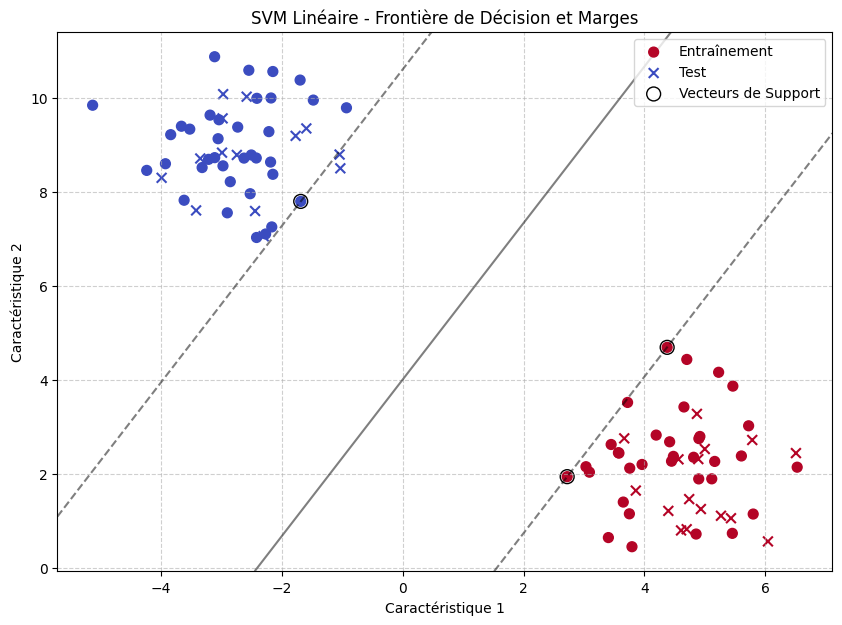


Nombre de vecteurs de support trouvés : 3
Coordonnées des vecteurs de support :
[[-1.68665271  7.79344248]
 [ 2.72110762  1.94665581]
 [ 4.375222    4.69333885]]


In [2]:
# --- 1. Génération de données linéairement séparables ---
# Crée 100 points autour de 2 centres distincts (2 classes)
# random_state assure la reproductibilité
X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                  cluster_std=1.0, random_state=42)

# --- 2. Division des données (entraînement / test) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 3. Création et entraînement du modèle SVM Linéaire ---
# Nous utilisons svm.SVC (Support Vector Classifier)
# et spécifions kernel='linear' pour un SVM linéaire.
# C=1.0 est un paramètre de régularisation (marge douce).
# Des valeurs plus faibles de C permettent une marge plus large mais plus d'erreurs.
linear_svm = svm.SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train, y_train)

# --- 4. Prédiction et Évaluation ---
y_pred = linear_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Données générées avec {X.shape[1]} caractéristiques.")
print(f"Taille de l'ensemble d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille de l'ensemble de test : {X_test.shape[0]} échantillons")
print(f"Précision du SVM linéaire sur l'ensemble de test : {accuracy:.4f}")

# --- 5. Visualisation ---
plt.figure(figsize=(10, 7))

# Afficher les points de données (entraînement et test)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=50, label='Entraînement')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, s=50, marker='x', label='Test')

# Créer une grille pour tracer la frontière de décision
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Créer la grille
xx = np.linspace(xlim[0], xlim[1], 50)
yy = np.linspace(ylim[0], ylim[1], 50)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T # Combinaison des points de la grille

# Prédire la classe pour chaque point de la grille
Z = linear_svm.decision_function(xy).reshape(XX.shape) # Utilise decision_function pour tracer les marges aussi

# Tracer la frontière de décision et les marges
# La frontière est où decision_function = 0
# Les marges sont où decision_function = -1 et +1
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Mettre en évidence les vecteurs de support
# Les vecteurs de support sont stockés dans l'attribut support_vectors_
support_vectors = linear_svm.support_vectors_
ax.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', label='Vecteurs de Support')

plt.title('SVM Linéaire - Frontière de Décision et Marges')
plt.xlabel('Caractéristique 1')
plt.ylabel('Caractéristique 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"\nNombre de vecteurs de support trouvés : {len(support_vectors)}")
print("Coordonnées des vecteurs de support :")
print(support_vectors)

# Exemple de code de traitement des données textuelles par le SVM

Taille entraînement: 7 textes
Taille test: 3 textes

Entraînement du modèle...
Entraînement terminé.

Évaluation sur l'ensemble de test...
Prédictions sur le test: [1 0 1]
Vraies étiquettes test: [1 0 0]

Précision (Accuracy) : 0.6667

Rapport de Classification :
              precision    recall  f1-score   support

 Négatif (0)       1.00      0.50      0.67         2
 Positif (1)       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3


Préparation de la visualisation...


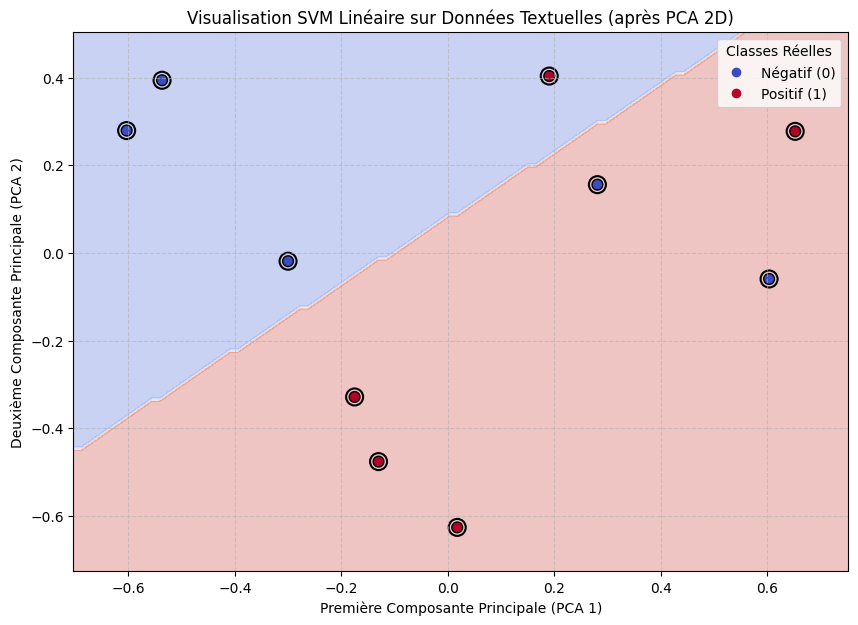

Visualisation terminée.


In [3]:
# --- 1. Données Textuelles d'Exemple ---
corpus = [
    "Ce film était absolument génial, super acteurs !",      # Positif (1)
    "Très déçu par ce produit, ne fonctionne pas bien.",   # Négatif (0)
    "Excellent service client, très réactif et utile.",    # Positif (1)
    "Une perte de temps et d'argent, horrible expérience.",# Négatif (0)
    "J'ai adoré la nourriture, c'était délicieux.",        # Positif (1)
    "Le livre était ennuyeux et mal écrit.",              # Négatif (0)
    "Magnifique paysage, vacances parfaites.",            # Positif (1)
    "Quelle arnaque, produit de mauvaise qualité.",       # Négatif (0)
    "Personnel sympathique et accueillant.",               # Positif (1)
    "Je ne recommande pas du tout, très mauvais.",         # Négatif (0)
]
labels = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

# --- 2. Division des données (entraînement / test) ---
X_train_text, X_test_text, y_train, y_test = train_test_split(
    corpus, labels, test_size=0.3, random_state=42
)

print(f"Taille entraînement: {len(X_train_text)} textes")
print(f"Taille test: {len(X_test_text)} textes\n")

# --- 3. Création du Pipeline (Vectorisation + Classification) ---
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('svm_linear', SVC(kernel='linear', C=1.0, probability=True))
])

# --- 4. Entraînement du Pipeline ---
print("Entraînement du modèle...")
pipeline.fit(X_train_text, y_train)
print("Entraînement terminé.\n")

# --- 5. Prédiction et Évaluation sur l'ensemble de test ---
print("Évaluation sur l'ensemble de test...")
y_pred = pipeline.predict(X_test_text)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Négatif (0)', 'Positif (1)'])
print(f"Prédictions sur le test: {y_pred}")
print(f"Vraies étiquettes test: {y_test}")
print(f"\nPrécision (Accuracy) : {accuracy:.4f}")
print("\nRapport de Classification :")
print(report)

# --- 6. Faire une prédiction sur un nouveau texte ---
# (Code identique à l'exemple précédent... omis pour la brièveté)
# print("="*30)
# ...
# print("="*30)


# --- 7. VISUALISATION (après entraînement) ---
print("\nPréparation de la visualisation...")

# Récupérer le vectorizer ajusté depuis le pipeline
vectorizer = pipeline.named_steps['tfidf']

# Transformer TOUTES les données textuelles (train + test) en TF-IDF
# pour les visualiser ensemble dans l'espace réduit
X_all_text = corpus # Utiliser tout le corpus pour la visualisation
y_all = labels
X_tfidf_all = vectorizer.transform(X_all_text) # Utiliser transform, pas fit_transform

# Réduire la dimensionnalité de la matrice TF-IDF à 2D avec PCA
pca = PCA(n_components=2, random_state=42)
# Ajuster PCA sur les données TF-IDF et les transformer
X_pca_all = pca.fit_transform(X_tfidf_all.toarray()) # .toarray() si la sortie est sparse

# Pour tracer la frontière, nous entraînons un NOUVEAU SVM
# *uniquement* sur les données réduites en 2D (PCA).
# Ceci est une simplification pour la visualisation. La frontière
# tracée ici est celle d'un SVM dans l'espace 2D PCA, qui approxime
# la projection de la frontière du SVM haute-dimension original.
svm_2d = SVC(kernel='linear', C=1.0)
svm_2d.fit(X_pca_all, y_all) # Entraîner sur toutes les données réduites

# Créer une grille de points dans l'espace 2D PCA
x_min, x_max = X_pca_all[:, 0].min() - 0.1, X_pca_all[:, 0].max() + 0.1
y_min, y_max = X_pca_all[:, 1].min() - 0.1, X_pca_all[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Prédire la classe pour chaque point de la grille avec le SVM 2D
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Créer le graphique
plt.figure(figsize=(10, 7))

# Tracer la frontière de décision et les régions colorées
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

# Tracer les points de données projetés en 2D par PCA
# Colorer les points selon leur vraie étiquette
scatter = plt.scatter(X_pca_all[:, 0], X_pca_all[:, 1], c=y_all,
                      cmap=plt.cm.coolwarm, edgecolors='k', s=60)

# Ajouter les vecteurs de support du modèle 2D (optionnel, pour info)
support_vectors_2d = svm_2d.support_vectors_
plt.scatter(support_vectors_2d[:, 0], support_vectors_2d[:, 1], s=150,
            facecolors='none', edgecolors='k', linewidth=1.5,
            label='Vecteurs de Support (2D)')


plt.title('Visualisation SVM Linéaire sur Données Textuelles (après PCA 2D)')
plt.xlabel('Première Composante Principale (PCA 1)')
plt.ylabel('Deuxième Composante Principale (PCA 2)')

# Créer une légende personnalisée
handles, _ = scatter.legend_elements()
legend_labels = ['Négatif (0)', 'Positif (1)']
plt.legend(handles, legend_labels, title="Classes Réelles")

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Visualisation terminée.")

# Exemple de code de traitement des données categorielles et numériques par le SVM

Données initiales :
   Age  Revenu  Genre      Ville  Achat
0   25   50000  Homme      Paris      0
1   45   80000  Femme       Lyon      1
2   30   65000  Femme      Paris      1
3   55   40000  Homme  Marseille      0
4   22   52000  Femme       Lyon      1


Taille entraînement: 8 échantillons
Taille test: 4 échantillons

Entraînement du modèle (avec prétraitement)...
Entraînement terminé.

Évaluation sur l'ensemble de test...
Prédictions sur le test: [1 1 0 1]
Vraies étiquettes test: [0 1 0 1]

Précision (Accuracy) : 0.7500

Rapport de Classification :
               precision    recall  f1-score   support

Non Achat (0)       1.00      0.50      0.67         2
    Achat (1)       0.67      1.00      0.80         2

     accuracy                           0.75         4
    macro avg       0.83      0.75      0.73         4
 weighted avg       0.83      0.75      0.73         4


Préparation de la visualisation...


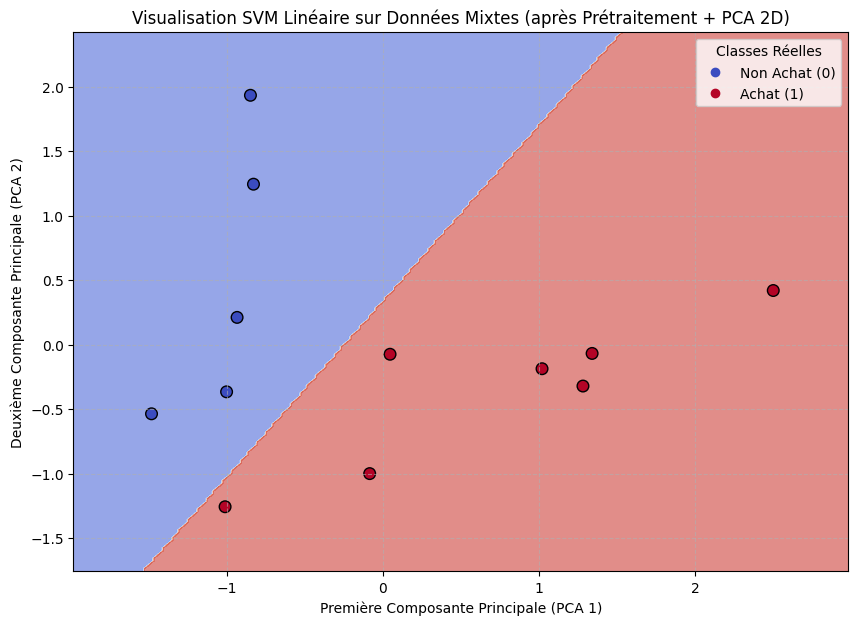

Visualisation terminée.


In [4]:
# --- 1. Création de Données d'Exemple avec Catégories ---
data = {
    'Age': [25, 45, 30, 55, 22, 38, 41, 29, 60, 33, 48, 50], # Ajout de points pour une meilleure visualisation
    'Revenu': [50000, 80000, 65000, 40000, 52000, 75000, 90000, 60000, 100000, 58000, 85000, 45000],
    'Genre': ['Homme', 'Femme', 'Femme', 'Homme', 'Femme', 'Homme', 'Femme', 'Homme', 'Femme', 'Homme', 'Femme', 'Homme'],
    'Ville': ['Paris', 'Lyon', 'Paris', 'Marseille', 'Lyon', 'Paris', 'Marseille', 'Lyon', 'Paris', 'Marseille', 'Lyon', 'Lyon'],
    'Achat': [0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0] # Variable cible
}
df = pd.DataFrame(data)

print("Données initiales :")
print(df.head()) # Affiche les 5 premières lignes
print("\n")

# Séparer les caractéristiques (X) et la cible (y)
X = df.drop('Achat', axis=1)
y = df['Achat']

# --- 2. Identification des types de colonnes ---
numerical_features = ['Age', 'Revenu']
categorical_features = ['Genre', 'Ville']

# --- 3. Création du Prétraitement avec ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 4. Création du Pipeline Complet (Prétraitement + Modèle SVM) ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', C=1.0, probability=True))
])

# --- 5. Division des données (entraînement / test) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify pour garder les proportions de classes

print(f"Taille entraînement: {X_train.shape[0]} échantillons")
print(f"Taille test: {X_test.shape[0]} échantillons\n")

# --- 6. Entraînement du Pipeline ---
print("Entraînement du modèle (avec prétraitement)...")
model_pipeline.fit(X_train, y_train)
print("Entraînement terminé.\n")

# --- 7. Prédiction et Évaluation sur l'ensemble de test ---
print("Évaluation sur l'ensemble de test...")
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
try:
    report = classification_report(y_test, y_pred, target_names=['Non Achat (0)', 'Achat (1)'], zero_division=0)
except ValueError:
     report = "Rapport de classification non disponible (pas assez d'échantillons pour une classe en test)."

print(f"Prédictions sur le test: {y_pred}")
print(f"Vraies étiquettes test: {y_test.values}")
print(f"\nPrécision (Accuracy) : {accuracy:.4f}")
print("\nRapport de Classification :")
print(report)


# --- 8. Faire une prédiction sur de nouvelles données ---
# (Code identique à l'exemple précédent... omis pour la brièveté)


# --- 9. VISUALISATION (après entraînement) ---
print("\nPréparation de la visualisation...")

# Récupérer le préprocesseur ajusté depuis le pipeline
fitted_preprocessor = model_pipeline.named_steps['preprocessor']

# Appliquer le prétraitement à TOUTES les données (X) pour la visualisation
X_processed_all = fitted_preprocessor.transform(X)

# Réduire la dimensionnalité des données prétraitées à 2D avec PCA
pca = PCA(n_components=2, random_state=42)
# Ajuster PCA sur les données prétraitées et les transformer
# Utiliser .toarray() si X_processed_all est une matrice sparse
X_pca_all = pca.fit_transform(X_processed_all if not hasattr(X_processed_all, 'toarray') else X_processed_all.toarray())

# Entraîner un NOUVEAU SVM *uniquement* sur les données réduites en 2D (PCA)
# pour pouvoir tracer sa frontière dans l'espace 2D.
svm_2d = SVC(kernel='linear', C=1.0)
svm_2d.fit(X_pca_all, y) # Entraîner sur toutes les données réduites et leurs vraies étiquettes y

# Créer une grille de points dans l'espace 2D PCA
x_min, x_max = X_pca_all[:, 0].min() - 0.5, X_pca_all[:, 0].max() + 0.5 # Marge élargie
y_min, y_max = X_pca_all[:, 1].min() - 0.5, X_pca_all[:, 1].max() + 0.5
h = .02  # pas de la grille
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Prédire la classe pour chaque point de la grille avec le SVM 2D
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Créer le graphique
plt.figure(figsize=(10, 7))

# Tracer la frontière de décision et les régions colorées
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)

# Tracer les points de données projetés en 2D par PCA
# Colorer les points selon leur vraie étiquette (y)
scatter = plt.scatter(X_pca_all[:, 0], X_pca_all[:, 1], c=y,
                      cmap=plt.cm.coolwarm, edgecolors='k', s=70)

plt.title('Visualisation SVM Linéaire sur Données Mixtes (après Prétraitement + PCA 2D)')
plt.xlabel('Première Composante Principale (PCA 1)')
plt.ylabel('Deuxième Composante Principale (PCA 2)')

# Créer une légende personnalisée
handles, _ = scatter.legend_elements()
legend_labels = ['Non Achat (0)', 'Achat (1)']
plt.legend(handles, legend_labels, title="Classes Réelles")

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Visualisation terminée.")

# Exemple de code de traitement données images par le SVM

Dataset chargé: 1797 échantillons, 64 caractéristiques (pixels)
Taille Train set: 1437 échantillons
Taille Test set: 360 échantillons
Données mises à l'échelle (StandardScaler)
Entraînement du modèle SVM linéaire...
Entraînement terminé.

Précision du SVM linéaire sur le jeu de test: 0.9528

Inspection de l'échantillon de test à l'indice: 257


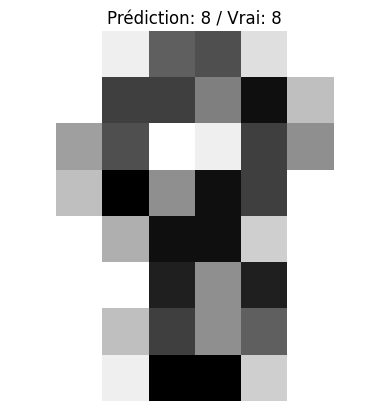

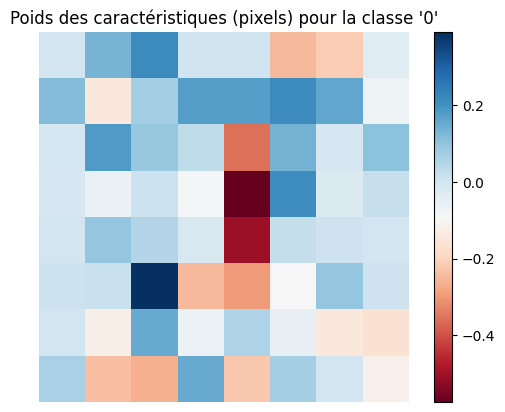

In [5]:
import random # Pour choisir un index aléatoire valide

# --- 1. Chargement des Données ---
# Utilisons load_digits (images 8x8) pour un exemple rapide
# Si tu veux le vrai MNIST (images 28x28), décommente la ligne fetch_openml
# Attention: fetch_openml peut nécessiter un téléchargement la première fois
digits = load_digits()
# mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
# X, y = mnist["data"], mnist["target"].astype(np.uint8)

X = digits.data
y = digits.target
image_shape = (8, 8) # (28, 28) si tu utilises fetch_openml('mnist_784')
n_samples, n_features = X.shape
print(f"Dataset chargé: {n_samples} échantillons, {n_features} caractéristiques (pixels)")

# --- 2. Séparation Train / Test ---
# Séparons les données AVANT toute mise à l'échelle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 # random_state pour la reproductibilité
)
print(f"Taille Train set: {len(X_train)} échantillons")
print(f"Taille Test set: {len(X_test)} échantillons") # Note: la taille du test set

# --- 3. Mise à l'échelle (Scaling) ---
# Très important pour les SVM !
scaler = StandardScaler()
# Adapter le scaler UNIQUEMENT sur les données d'entraînement
X_train_scaled = scaler.fit_transform(X_train)
# Appliquer la MÊME transformation aux données de test
X_test_scaled = scaler.transform(X_test)
print("Données mises à l'échelle (StandardScaler)")

# --- 4. Entraînement du SVM Linéaire ---
# Utilisation de LinearSVC, souvent plus rapide pour les cas linéaires purs
# Correction Erreur 1: Augmentation de max_iter
# On utilise aussi dual=False qui est souvent recommandé quand n_samples > n_features
# et peut aider à la convergence.
linear_svm = LinearSVC(max_iter=5000, random_state=42, dual=False, C=1.0) # Augmentation de max_iter
# Alternative:
# linear_svm = SVC(kernel='linear', max_iter=5000, C=1.0, random_state=42)

print("Entraînement du modèle SVM linéaire...")
linear_svm.fit(X_train_scaled, y_train)
print("Entraînement terminé.")

# --- 5. Évaluation sur le Test Set ---
y_pred = linear_svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrécision du SVM linéaire sur le jeu de test: {accuracy:.4f}")

# --- 6. Inspection d'une Prédiction Spécifique ---
# Correction Erreur 2: Choisir un index VALIDE pour le jeu de test
# Générons un index aléatoire DANS LES LIMITES du jeu de test
num_test_samples = len(X_test_scaled)
if num_test_samples > 0:
    # idx = 5 # Choisir un index spécifique (ex: 5)
    idx = random.randint(0, num_test_samples - 1) # Choisir un index aléatoire valide
    print(f"\nInspection de l'échantillon de test à l'indice: {idx}")

    # Récupérer l'image originale (non-scalée) pour l'affichage
    image_original = X_test[idx]
    image_2d = image_original.reshape(image_shape)

    # Récupérer l'image scalée pour la prédiction
    # Doit être de forme (1, n_features) pour predict()
    image_scaled_for_prediction = X_test_scaled[idx].reshape(1, -1)

    # Faire la prédiction sur cette image unique
    prediction = linear_svm.predict(image_scaled_for_prediction)[0]
    true_label = y_test[idx]

    # Affichage
    plt.imshow(image_2d, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Prédiction: {prediction} / Vrai: {true_label}')
    plt.axis('off')
    plt.show()

else:
    print("\nLe jeu de test est vide, impossible d'inspecter une prédiction.")

# --- Optionnel: Afficher les coefficients (pour comprendre ce que le modèle a appris) ---
# Ceci est plus pertinent pour la classification binaire, mais peut donner une idée
if hasattr(linear_svm, 'coef_'):
#     # Pour LinearSVC, coef_ a la forme (n_classes, n_features) si multi-classe OvR
#     # Prenons les coefficients pour la classe '0' par exemple (si elle existe)
    if 0 in linear_svm.classes_:
        idx_class_0 = list(linear_svm.classes_).index(0)
        coef_class_0 = linear_svm.coef_[idx_class_0]
        plt.figure()
        plt.imshow(coef_class_0.reshape(image_shape), cmap=plt.cm.RdBu, interpolation='nearest')
        plt.title("Poids des caractéristiques (pixels) pour la classe '0'")
        plt.colorbar()
        plt.axis('off')
        plt.show()

# QR Code pour le projet sur Github

In [6]:
# Le lien à encoder dans le QR code
lien_github = "https://github.com/barhador/Presentation_SVM"

# Nom du fichier image pour le QR code
nom_fichier = "qrcode_presentation_svm.png"

# Configuration du QR code (optionnel, mais recommandé pour la qualité)
qr = qrcode.QRCode(
    version=1,  # Contrôle la taille du QR code (1-40). None pour automatique.
    error_correction=qrcode.constants.ERROR_CORRECT_M, # Niveau de correction d'erreur (L, M, Q, H)
    box_size=10, # Taille de chaque "carré" du QR code en pixels
    border=4,    # Épaisseur de la bordure blanche (minimum 4 recommandé)
)

# Ajouter les données (le lien) au QR code
qr.add_data(lien_github)
qr.make(fit=True) # Génère le QR code en s'assurant que les données rentrent

# Créer l'image du QR code (nécessite Pillow/PIL)
img = qr.make_image(fill_color="black", back_color="white")

# Sauvegarder l'image dans un fichier
try:
    img.save(nom_fichier)
    chemin_absolu = os.path.abspath(nom_fichier)
    print(f"QR Code généré avec succès !")
    print(f"Le fichier a été sauvegardé sous : {chemin_absolu}")
except Exception as e:
    print(f"Une erreur est survenue lors de la sauvegarde du fichier : {e}")

QR Code généré avec succès !
Le fichier a été sauvegardé sous : c:\Users\batud\OneDrive\Masaüstü\Git\Presentation_SVM\qrcode_presentation_svm.png
